In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
import sys

import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = "/content/drive/MyDrive/OMSCS/DL/FinalProject"
sys.path.append(os.path.abspath(DIR))

from team36.mnist.vgg import VGG
from team36.training import train, validate
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.defenses.fast_gradient_sign_method_loss import FastGradientSignMethodLoss

NAME = "mnist"
DATA_SET_CLASS = torchvision.datasets.MNIST
image_size = 28
in_channels = 1

In [ ]:
DATA_DIR = f'{DIR}/data'

training_set = DATA_SET_CLASS(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())

training_indices, validation_indices = train_test_split(
    range(len(training_set)),
    test_size=0.1,
)
training_split = torch.utils.data.Subset(training_set, training_indices)
validation_split = torch.utils.data.Subset(training_set, validation_indices)

print(f"{len(training_split)} in training set")
print(f"{len(validation_split)} in validation set")

54000 in training set
6000 in validation set


Epoch: [0][0/1688]	Loss 2.7191 (2.7191)	Prec @1 0.0938 (0.0938)	
Epoch: [0][10/1688]	Loss 1.8841 (2.0570)	Prec @1 0.4062 (0.3438)	
Epoch: [0][20/1688]	Loss 1.3875 (1.7213)	Prec @1 0.5000 (0.4940)	
Epoch: [0][30/1688]	Loss 1.0116 (1.4976)	Prec @1 0.7812 (0.5796)	
Epoch: [0][40/1688]	Loss 0.5303 (1.3369)	Prec @1 0.9375 (0.6418)	
Epoch: [0][50/1688]	Loss 0.6290 (1.2001)	Prec @1 0.8125 (0.6900)	
Epoch: [0][60/1688]	Loss 0.5133 (1.0951)	Prec @1 0.8750 (0.7228)	
Epoch: [0][70/1688]	Loss 0.6537 (1.0113)	Prec @1 0.7812 (0.7496)	
Epoch: [0][80/1688]	Loss 0.5274 (0.9473)	Prec @1 0.8750 (0.7670)	
Epoch: [0][90/1688]	Loss 0.5466 (0.8998)	Prec @1 0.9062 (0.7775)	
Epoch: [0][100/1688]	Loss 0.5870 (0.8533)	Prec @1 0.8125 (0.7896)	
Epoch: [0][110/1688]	Loss 0.4063 (0.8128)	Prec @1 0.9688 (0.8015)	
Epoch: [0][120/1688]	Loss 0.4026 (0.7776)	Prec @1 0.9375 (0.8115)	
Epoch: [0][130/1688]	Loss 0.3861 (0.7439)	Prec @1 0.9375 (0.8206)	
Epoch: [0][140/1688]	Loss 0.3112 (0.7203)	Prec @1 0.9062 (0.8256)	
Epoch:

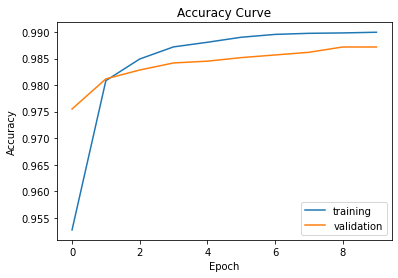

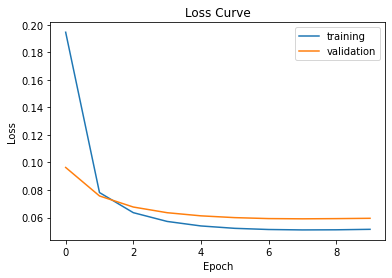

Best Validation Acccuracy: 0.9872


In [ ]:
learning_rate = 5e-4
batch_size = 32
momentum = 5e-1
weight_decay = 5e-2
epochs = 10

training_loader = torch.utils.data.DataLoader(training_split, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(validation_split, batch_size=100, shuffle=False)

model = VGG(image_size=image_size, in_channels=in_channels).cuda()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum, weight_decay=weight_decay)

best = 0.0
best_cm = None
best_model = None
train_accuracy_history = []
train_loss_history = []
validation_accuracy_history = []
validation_loss_history = []
for epoch in range(epochs):
    train_acc, train_loss = train(epoch, training_loader, model, optimizer, criterion)
    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    acc, cm, loss = validate(epoch, test_loader, model, criterion)
    validation_accuracy_history.append(acc)
    validation_loss_history.append(loss)
    
    print("Epoch {0} | Training accuracy: {1}% | Validation accuracy: {2}%".format(epoch, train_acc, acc))
    
    if acc > best:
        best = acc
        best_cm = cm
        best_model = copy.deepcopy(model)
        
training_curve, = plt.plot(train_accuracy_history, label='training')
validation_curve, = plt.plot(validation_accuracy_history, label='validation')
plt.title('Accuracy Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

training_curve, = plt.plot(train_loss_history, label='training')
validation_curve, = plt.plot(validation_loss_history, label='validation')
plt.title('Loss Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Best Validation Acccuracy: {:.4f}'.format(best))

In [ ]:
filename = f"{DIR}/checkpoints/{NAME}-vgg.pth"
torch.save(best_model.state_dict(), filename)